# Louvain Performance Benchmarking

This notebook benchmarks performance improvement of running Louvain clustering within cuGraph against NetworkX.

Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 04/04/2019

RAPIDS Versions: 0.6.0

Test Hardware

    GP100 32G, CUDA 9,2
    Dual Intel(R) Xeon(R) CPU E5-2643 v4 @ 3.40GHz
    64GB system memory



__Note__ Comparison against published results


The cuGraph blog post included performance numbers that were collected over a year ago.  For the test graphs, int32 values are now used.  That improves GPUs performance.  Additionally, the initial benchamrks were measured on a P100 GPU. 

This test only comparse the modularity scores and a success is if the scores are within 15% of each other.  That comparison is done by adjusting the NetworkX modularity score and then verifying that the cuGraph score is higher.

cuGraph did a full validation of NetworkX results against cuGraph results.  That included cross-validation of every cluster.  That test is very slow and not included here

In [9]:
# Import needed libraries
import time
import cugraph
import cudf
import numpy as np
from collections import OrderedDict

In [10]:
# NetworkX libraries
import community
import networkx as nx
from scipy.io import mmread

### Define the test data

In [11]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [12]:
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    d = mmread(mm_file).asfptype()
    M = d.tocsr()
    
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')
        
    return M

In [13]:
def cugraph_call(M):

    # data
    row_offsets = cudf.Series(M.indptr)
    col_indices = cudf.Series(M.indices)
    
    # create graph 
    G = cugraph.Graph()
    G.add_adj_list(row_offsets, col_indices, values)

    # cugraph Louvain Call
    print('  cuGraph Solving... ')
    t1 = time.time()
    df, mod = cugraph.nvLouvain(G)    
    t2 = time.time() - t1
    return t2, mod



In [14]:
def networkx_call(M):
   
    # Directed NetworkX graph
    Gnx = nx.Graph(M)

    # Networkx 
    print('  NetworkX Solving... ')
    t1 = time.time()
    parts = community.best_partition(Gnx)
    t2 = time.time() - t1
    
    # Calculating modularity scores for comparison 
    mod = community.modularity(parts, Gnx)    
    
    return t2, mod

### Run the benchmarks

In [7]:
perf  = []
names = []

for k,v in data.items():
    M = read_mtx_file(v)
    tr, modc = cugraph_call(M)
    tn, modx = networkx_call(M)
    
    speedUp = (tn / tr)
    names.append(k)
    perf.append(speedUp)
    
    mod_delta = (0.85 * modx)
    
    print(str(speedUp) + "x fatser =>  cugraph " + str(tr) + " vs " + str(tn))
    print("Modularity =>  cugraph " + str(modc) + " should be greater than " + str(mod_delta))

Reading ./data/preferentialAttachment.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
8054.308719196283x fatser =>  cugraph 0.2728421688079834 vs 2197.555059194565
Reading ./data/caidaRouterLevel.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
3660.6224597205246x fatser =>  cugraph 0.0872032642364502 vs 319.2182276248932
Reading ./data/coAuthorsDBLP.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
8346.25085628359x fatser =>  cugraph 0.08561849594116211 vs 714.5934450626373
Reading ./data/dblp-2010.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
6430.3236751743425x fatser =>  cugraph 0.09429121017456055 vs 606.3230011463165
Reading ./data/citationCiteseer.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
8106.781294718824x fatser =>  cugraph 0.09513401985168457 vs 771.2306926250458
Reading ./data/coPapersDBLP.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10592.845769343247x fatser =>  cugraph 0.18506693840026855 vs 1960.385535478592
Reading ./data/coPapersCitesee

### plot the output

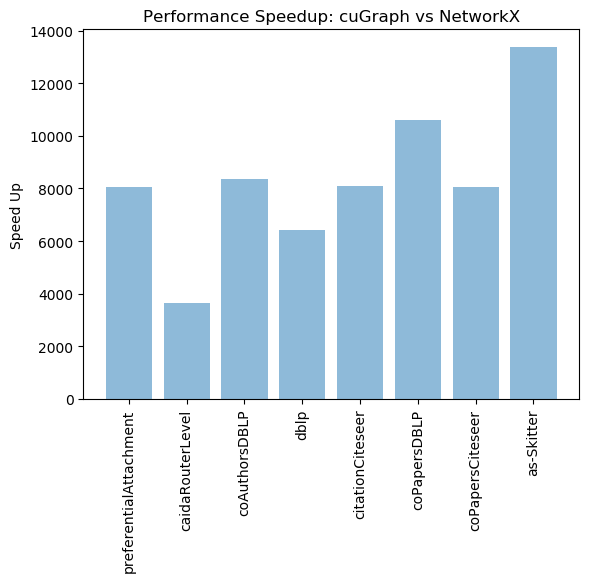

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
y_pos = np.arange(len(names))
 
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, names)
plt.ylabel('Speed Up')
plt.title('Performance Speedup: cuGraph vs NetworkX')
plt.xticks(rotation=90) 
plt.show()